In [1]:
import pandas as pd
import numpy as np
import datetime
import time

from tda import auth, client
import json
from config import api_key, redirect_uri, token_path, account_id, executable_path

# Machine learning libraries
from sklearn.svm import SVC
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, classification_report
import talib as ta
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
# set connection with brocker account
connection = get_account_acess(api_key, redirect_uri, token_path, account_id, executable_path)

In [3]:
# get historical data
data = pd.DataFrame(connection.get_price_history_every_minute('TSLA', 
                                                              start_datetime = datetime.datetime.fromisoformat('2022-04-14 09:30:00'),
                                                              need_extended_hours_data=False).json()['candles'])
data['datetime'] = data['datetime'].apply(lambda x : datetime.datetime.fromtimestamp(x/1000.0))
data['datetime'] = data['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d %H:%M:%S'))
data = data.set_index('datetime')

In [6]:
data = data[data.index<='2022-04-20 15:59:00']

In [7]:
# define data for testing
data_test =  data[data.index>='2022-04-20 09:30:00']
data_test_signal = data_cleaning_engineering(data)

In [28]:
# time range with 1 min based on testing data
position_range = np.arange(1170,1560,1)

In [30]:
%%time
d_result_position_signal = {}
for position in position_range:
    df = data.iloc[:position]
    df_clean = data_cleaning_engineering(df)
    timestamp, prediction = train_classifier_predict(df_clean)
    d_result_position_signal[timestamp[0]] = int(prediction)

CPU times: total: 53min 30s
Wall time: 54min 32s


In [63]:
df_test_pred = pd.DataFrame(d_result_position_signal.items(), columns=['datetime','Pred_Signal']).iloc[3:,:]

'2022-04-20 09:32:00'

In [64]:
df_quotes = pd.read_csv('df_result_position_signal_4_20.csv', index_col='Unnamed: 0')
df_quotes.index.name='datetime'
df_quotes = df_quotes.reset_index()
df_quotes['datetime'] = df_quotes['datetime'].apply(lambda x: x+':00')

In [66]:
df_test_pred = pd.merge(df_test_pred, df_quotes[['quote','datetime']], how='left', left_on='datetime', right_on='datetime')
df_test_pred

,datetime,Pred_Signal,quote
0,2022-04-20 09:32:00,-1,1029.5300
1,2022-04-20 09:33:00,0,1026.9399
2,2022-04-20 09:34:00,1,1025.6000
3,2022-04-20 09:35:00,-1,1028.5699
4,2022-04-20 09:36:00,0,1022.3400
...,...,...,...
382,2022-04-20 15:54:00,-1,980.2200
383,2022-04-20 15:55:00,-1,978.9800
384,2022-04-20 15:56:00,-1,977.9600
385,2022-04-20 15:57:00,-1,977.8500


In [67]:
df_results = pd.merge(data_test_signal, df_test_pred.set_index('datetime'), how='left', left_index= True, right_index=True)

In [68]:
df_pred = df_results[df_results.index>='2022-04-20 09:30:00']
df_pred = df_pred.dropna()
df_pred = df_pred.reset_index()
df_pred['Pred_Signal'] = df_pred['Pred_Signal'].astype(int)

In [69]:
df_pred.Datetime = df_pred.datetime.apply(lambda x: str(x))
df_pred.Datetime = df_pred.datetime.apply(lambda x: x[:-6])
df_pred['Open_shift'] = df_pred['open']-2
df_pred['Pred_Signal_switch'] = correct_signals(df_pred['Pred_Signal'])
df_pred['Signal_switch'] = correct_signals(df_pred['Signal'])
df_pred['Signal_m'] = df_pred['Signal'].apply(lambda x: ' ' if x==0 else x)
df_pred['Pred_Signal_m'] = df_pred['Pred_Signal'].apply(lambda x: ' ' if x==0 else x)
df_pred['Pred_Signal_switch'] = df_pred['Pred_Signal_switch'].apply(lambda x: ' ' if x==0 else x)
df_pred['Signal_switch'] = df_pred['Signal_switch'].apply(lambda x: ' ' if x==0 else x)

<ipython-input-69-93871bbff5d5>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_pred.Datetime = df_pred.datetime.apply(lambda x: str(x))


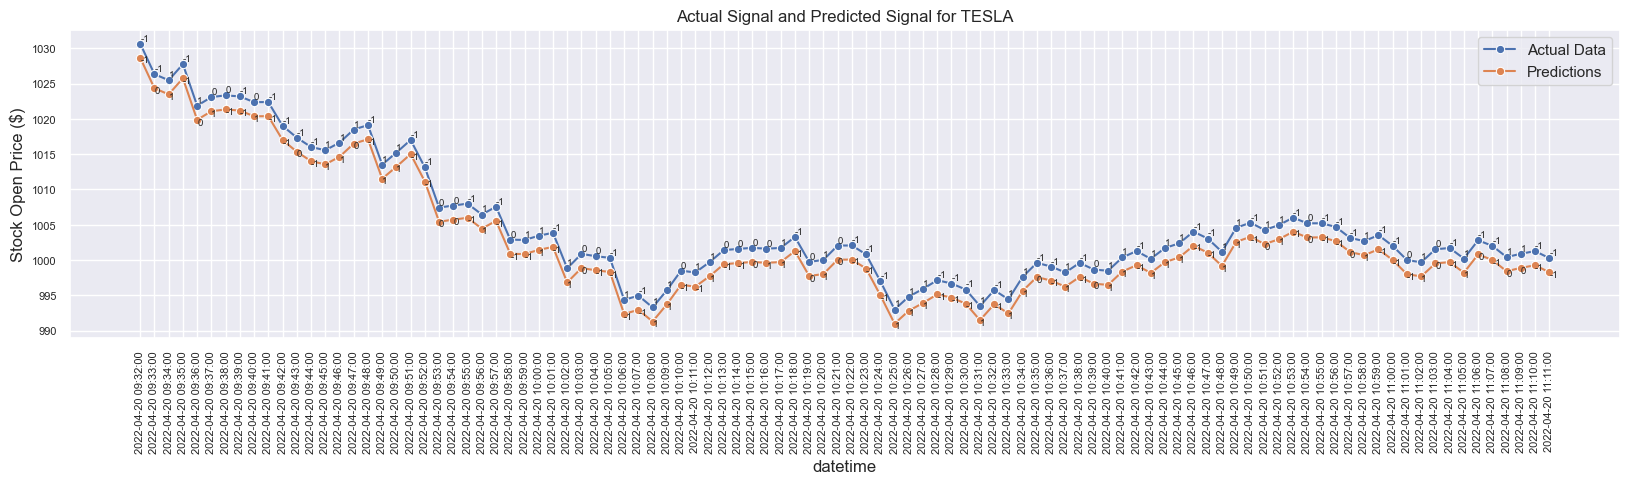

In [70]:
plot_predict_signal(df_pred[:100], col_orig_signal='Signal', col_pred_signal='Pred_Signal', figsize=(20,4))

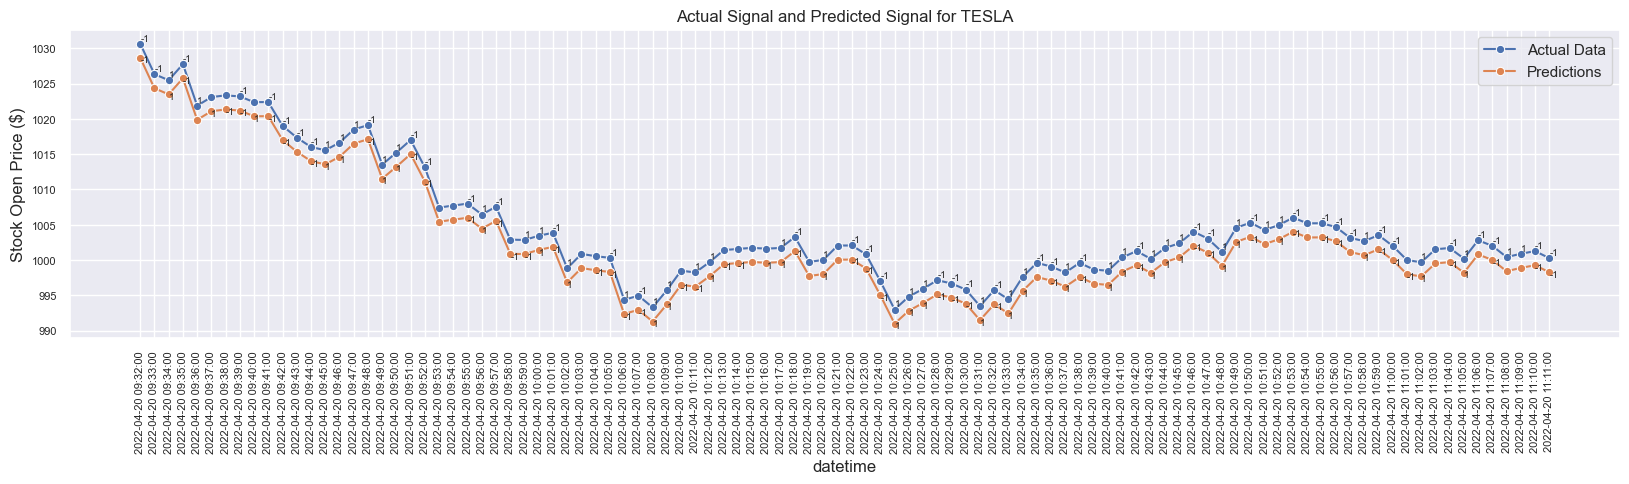

In [71]:
# Excluding Hold Position Signal (0)
plot_predict_signal(df_pred[:100], col_orig_signal='Signal_m', col_pred_signal='Pred_Signal_m', figsize=(20,4))

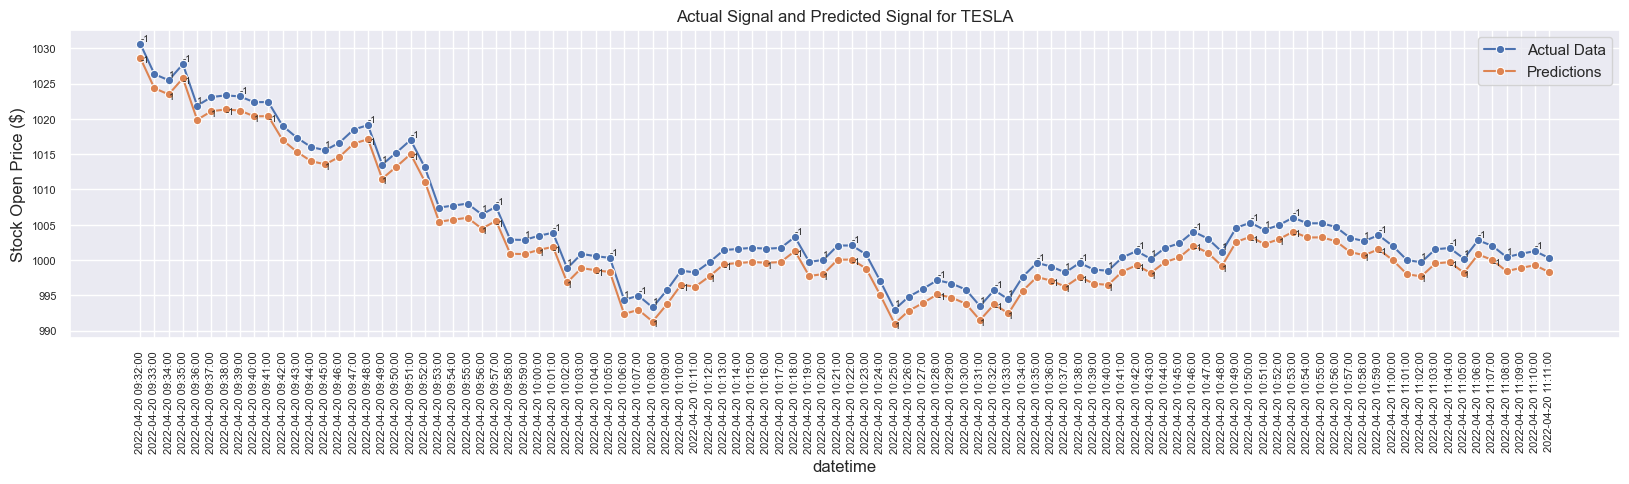

In [72]:
# Structurize Signal (111-11-1)-(1-1-1)
plot_predict_signal(df_pred[:100], col_orig_signal='Signal_switch', col_pred_signal='Pred_Signal_switch', figsize=(20,4))

In [73]:
df_pred_ret = df_pred[['datetime','quote', 'Pred_Signal_switch']]
df_pred_ret = df_pred_ret[df_pred_ret['Pred_Signal_switch'].isin([-1,1])]

# calculate pct return at each switch signal
df_pred_ret['Return'] = 100*df_pred_ret['quote'].pct_change()
df_pred_ret['Return'] = np.where(df_pred_ret['Pred_Signal_switch']==-1, df_pred_ret['Return'], np.nan)
df_pred_ret= df_pred_ret.reset_index(drop=True)

df_pred_ret['cum_sum_return'] = df_pred_ret['Return'].cumsum()
# df_pred_ret['cumul_compaund_return'] =  (1 + df_pred_ret.Return).cumprod() - 1  # (df_pred_ret['Return']+1000).cumprod()
# df_pred_ret['cumul_compaund_return'].iloc[0] = 1000

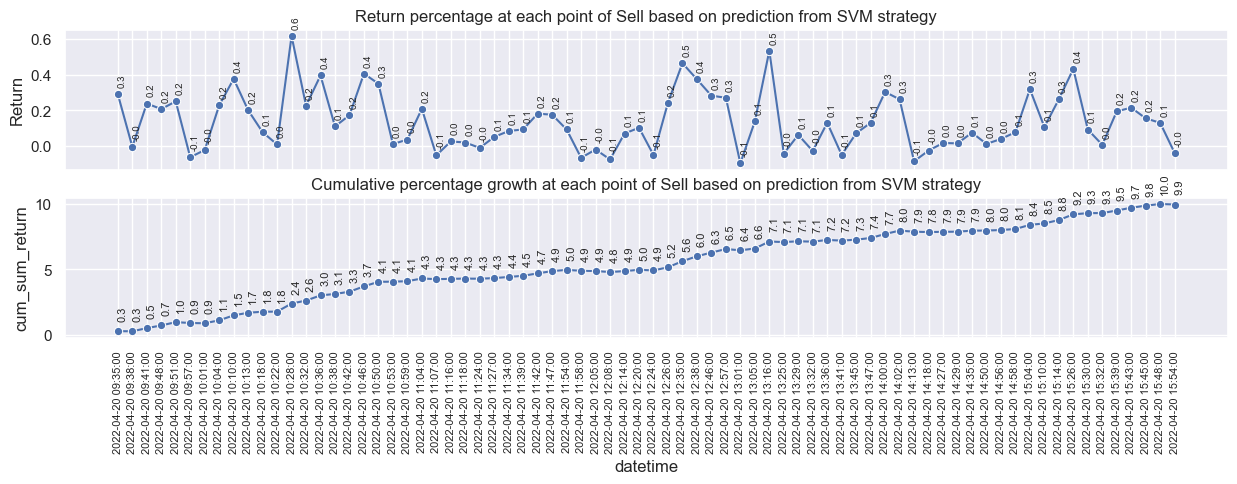

In [82]:
fig, ax = plt.subplots(2,1, figsize=(15,4))

ax[0].set_title('Return percentage at each point of Sell based on prediction from SVM strategy')
ax[0].set_ylabel('Return, pct')
plt.setp(ax[0].get_xticklabels(), visible=False)
sns.lineplot(x='datetime', y='Return', data=df_pred_ret, marker='o', ax=ax[0])
for xx,yy,m in df_pred_ret[['datetime','Return','Return']].dropna().values:
        ax[0].text(xx,yy+0.05,round(m,1), size =7, rotation =90)

ax[1].set_title('Cumulative percentage growth at each point of Sell based on prediction from SVM strategy')
plt.setp(ax[1].get_xticklabels(), rotation=90, size =8)
sns.lineplot(x='datetime', y='cum_sum_return', data=df_pred_ret, marker='o', ax=ax[1])
for xx,yy,m in df_pred_ret[['datetime','cum_sum_return','cum_sum_return']].dropna().values:
        ax[1].text(xx,yy+0.9,round(m,1), size =8, rotation =90)
        
# plt.tight_layout()
plt.show()

In [79]:
df_pred_ret

,datetime,quote,Pred_Signal_switch,Return,cum_sum_return
0,2022-04-20 09:32:00,1029.5300,-1,NaN,NaN
1,2022-04-20 09:34:00,1025.6000,1,NaN,NaN
2,2022-04-20 09:35:00,1028.5699,-1,0.289577,0.289577
3,2022-04-20 09:37:00,1021.4900,1,NaN,NaN
4,2022-04-20 09:38:00,1021.4400,-1,-0.004895,0.284682
5,2022-04-20 09:40:00,1019.2900,1,NaN,NaN
6,2022-04-20 09:41:00,1021.7100,-1,0.237420,0.522102
7,2022-04-20 09:45:00,1016.8500,1,NaN,NaN
8,2022-04-20 09:48:00,1018.9500,-1,0.206520,0.728622
9,2022-04-20 09:49:00,1013.4700,1,NaN,NaN
